In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%reload_ext tensorboard

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
import datetime
from tqdm import tqdm
import logging
import random

In [3]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [4]:
%%capture
!pip3 install -e gym-go

In [5]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [6]:
BOARD_SIZE = 7

# Machine Learning Models
Actor-Critic method

In [7]:
from tensorflow.keras import layers

In [8]:
def make_dqn():
    inputs = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 4), name="board")
    valid_inputs = layers.Input(shape=(BOARD_SIZE**2 + 1,), name="valid_moves")
    
    x = layers.Flatten()(inputs)
    
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    moves = layers.Dense(50)(x)
    
#     # Dense block
#     num_layers = 8
#     growth_rate = 4
#     x = inputs
#     for i in range(num_layers):
#         y = tf.keras.Sequential([
#             layers.Conv2D(filters=growth_rate, kernel_size=3, padding="same", bias_initializer='ones'),
#             layers.BatchNormalization(),
#             layers.ReLU(),
#         ], name='dense_layer_{}'.format(i))(x)
#         x = layers.Concatenate()([x,y])
    
#     moves = layers.Conv2D(filters=50, kernel_size=BOARD_SIZE, padding="valid", name="all_moves")(x)
    
#     moves = layers.Flatten()(moves)
    
    valid_moves = layers.Multiply(name='moves')([moves, valid_inputs])
    
    model = tf.keras.Model(inputs=[inputs, valid_inputs], outputs=valid_moves, name='DQN')
    return model

In [9]:
dqn = make_dqn()

In [10]:
dqn.summary()

Model: "DQN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 7, 7, 4)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 196)          0           board[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          100864      flatten[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512)          2048        dense[0][0]                      
________________________________________________________________________________________________

In [11]:
dqn.load_weights('tmp/dqn.h5')

In [12]:
opponent = tf.keras.models.clone_model(dqn)
target_policy = tf.keras.models.clone_model(dqn)

### Initialization of models 
should be random if the models are fresh

In [13]:
def feed_forward(states, model):
    invalid_moves = states[:,:,:,2].reshape((-1,49))
    invalid_moves = np.insert(invalid_moves, BOARD_SIZE**2, 0, axis=1)
    valid_moves = 1 - invalid_moves
    moves = model([states.astype(np.float32), valid_moves.astype(np.float32)])
    return moves

In [14]:
from sklearn import preprocessing
def state_responses(states, taken_actions=None, next_states=None):
    move_values = feed_forward(states, dqn)
    
    num_states = states.shape[0]
    
    fig = plt.figure(figsize=(6, num_states * 3))
    num_cols = 2 if next_states is None else 3
    for i in range(num_states):
        plt.subplot(num_states,num_cols,1 + num_cols*i)
        plt.axis('off')
        plt.title('Board')
        plt.imshow(states[i][:,:,[0,1,3]].astype(np.float))

        plt.subplot(num_states,num_cols,2 + num_cols*i)
        plt.axis('off')
        plt.title('DQN\n{:.2f}L {:.2f}H {:.2f}P'
                  .format(np.min(move_values[i][:-1]), 
                          np.max(move_values[i][:-1]), 
                          move_values[i][-1]))
        plt.imshow(tf.reshape(move_values[i][:-1], (BOARD_SIZE, BOARD_SIZE)))
        
        if next_states is not None:
            assert taken_actions is not None and len(taken_actions) == len(next_states)
            if i < next_states.shape[0]:
                plt.subplot(num_states,num_cols, 3 + num_cols*i)
                plt.axis('off')
                plt.title('Taken Action: {}'.format(taken_actions[i]))
                plt.imshow(next_states[i][:,:,[0,1,3]].astype(np.float))

    plt.tight_layout()
    return fig

In [15]:
state = go_env.reset()
start_state = np.copy(state)
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [16]:
states = state.transpose(1,2,0).reshape(1, BOARD_SIZE, BOARD_SIZE, 4)

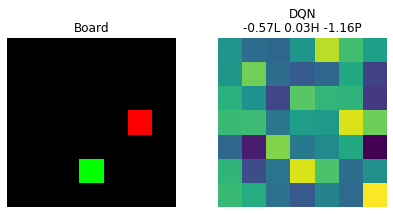

In [17]:
plt.show(state_responses(states))

# Training Setup

### Hyperparameters

In [18]:
NUM_EPISODES = 2000
BATCH_SIZE = 1024
MAX_STEPS = 3 * BOARD_SIZE**2
REPLAY_MEM_SIZE = 2e4

LEARNING_RATE = 1e-3
OPPONENT_UPDATE = 200

EPSILON = 1
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.1

GAMMA = 0.9
TARGET_UPDATE = 1 # number of episodes to update the target critic model

In [19]:
from collections import deque

In [20]:
replay_mem = deque(maxlen=int(REPLAY_MEM_SIZE))

### Metrics and Tensorboard

Metrics

In [21]:
metrics = {}
for metric_key in ['loss']:
    metrics[metric_key] = tf.keras.metrics.Mean('dqn_{}'.format(metric_key), dtype=tf.float32)

Tensorboard

In [22]:
summary_writers = {}
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
for summary_key in ['main']:
    log_dir = 'logs/dqn/{}/{}'.format(current_time, summary_key)
    summary_writers[summary_key] = tf.summary.create_file_writer(log_dir)

In [23]:
import io
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

### Functions

In [24]:
def random_weighted_action(move_weights):
    move_weights = preprocessing.normalize(move_weights, norm='l1')

    if np.sum(move_weights) <= 0:
        # Pass
        return None
    
    action_1d = np.random.choice(np.arange(BOARD_SIZE**2 + 1), p=move_weights[0])
    if action_1d == BOARD_SIZE**2:
        action = None
    else:
        action = (action_1d // BOARD_SIZE, action_1d % BOARD_SIZE)
    return action

In [25]:
def argmax_actval(move_weights):
    action_1d = np.argmax(move_weights, axis=1).item()
    if action_1d == BOARD_SIZE**2:
        action = None
    else:
        action = (action_1d // BOARD_SIZE, action_1d % BOARD_SIZE)
    return action

In [26]:
def random_action(state):
    """
    Assumed to be (BOARD_SIZE, BOARD_SIZE, 4)
    """
    invalid_moves = state[:,:,2].reshape((1,-1))
    invalid_moves = np.insert(invalid_moves, BOARD_SIZE**2, 0, axis=1)
    move_weights = 1 - invalid_moves

    action = random_weighted_action(move_weights)
    
    return action

In [27]:
def get_action(policy, state, epsilon):
    """
    Gets an action based on exploration/exploitation
    """
    if state.shape[0] == 4:
        # State shape will be (BOARD_SIZE, BOARD_SIZE, 4)
        state = state.transpose(1,2,0)
            
    epsilon_choice = np.random.uniform()
    if epsilon_choice < epsilon:
        # Random move
        logging.debug("Exploring a random move")
        action = random_action(state)
        
    else:
        # policy makes a move
        logging.debug("Exploiting policy's move")
        reshaped_state = state.reshape(1, BOARD_SIZE, BOARD_SIZE, 4).astype(np.float32)
        
        move_weights = feed_forward(reshaped_state, policy)
        
        if (np.max(move_weights) == 0):
            logging.warning("DQN could not determine any moves. Taking a random move")
            action = random_action(state)
        else:
            action = argmax_actval(move_weights)
        
    return action

In [28]:
def get_value_for_action(move_values, actions):
    '''
    Get value from board_values based on action, or take the passing_values if the action is None
    '''
    action_values = tf.gather_nd(move_values, [(i, a[0] * BOARD_SIZE + a[1]) if a is not None 
                                                    else (i, BOARD_SIZE**2) 
                                                    for i, a in enumerate(actions)])
    return action_values

In [29]:
def get_batch_obs(size=BATCH_SIZE):
    '''
    Get a batch of orig_states, actions, states, rewards, terminals as np array out of replay memory
    '''
    
    # States were (BATCH_SIZE, 4, BOARD_SIZE, BOARD_SIZE)
    # Convert them to (BATCH_SIZE, BOARD_SIZE, BOARD_SIZE, 4)
    batch = random.sample(replay_mem, size)
    batch = list(zip(*batch))
    orig_states = np.array(list(batch[0]), dtype=np.float32).transpose(0,2,3,1)
    actions = np.array(list(batch[1]))
    states = np.array(list(batch[2]), dtype=np.float32).transpose(0,2,3,1)
    rewards = np.array(list(batch[3]), dtype=np.float32)
    terminals = np.array(list(batch[4]), dtype=np.uint8)
    
    return orig_states, actions, states, rewards, terminals
    

In [30]:
def max_action_vals(states, actval_func):
    '''
    The maximum action value (including passing) given the states
    '''
    move_vals = feed_forward(states, actval_func)
    max_vals = tf.reduce_max(move_vals, axis=1)
    return max_vals

In [31]:
mean_squared_error = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.SUM)

In [32]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
def update_dqn():
    """
    Optimizes the critic in one step and updates the critic loss metric
    """
    states, actions, next_states, rewards, terminals  = get_batch_obs()
    
    # get values for next state
    next_state_vals = max_action_vals(next_states, target_policy)
    
    batch_size = states.shape[0]
    
    with tf.GradientTape() as tape:
        move_vals = feed_forward(states, dqn)
        action_vals = get_value_for_action(move_vals, actions)
        val_loss = mean_squared_error(rewards + GAMMA * next_state_vals * (1-terminals), action_vals) / batch_size
    
    metrics['loss'](val_loss)
    
    # compute and apply gradients
    gradients = tape.gradient(val_loss, dqn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, dqn.trainable_variables))

In [33]:
def train(episode):
    """
    Plays out a game, and iteratively updates the models at each step
    """
    global EPSILON
    
    # Basic setup
    done = False
    num_of_turns = 0
    state = go_env.reset()
    rewards = []
    
    while not done and num_of_turns <= MAX_STEPS:
        # Copy state for memory
        orig_state = np.copy(state)
        
        black_action = get_action(dqn, state, EPSILON)
        if black_action is None:
            logging.debug("Black (actor) passed")
            
        state, reward, done, info = go_env.step(black_action)
        num_of_turns += 1
        rewards.append(reward)
        
        # Update the critic and then actor if we have enough events
        if len(replay_mem) >= BATCH_SIZE:
            update_dqn()        
    
            # Update exploration/exploitation
            if EPSILON > EPSILON_MIN:
                EPSILON *= EPSILON_DECAY
                logging.debug("Epsilon decayed to {}".format(EPSILON))
            
        if done:
            # Add to memory
            replay_mem.append((orig_state, black_action, np.copy(state), reward, done))
            break
            
        # opponent makes a move
        # swap the black and white layers
        temp = np.copy(state[0])
        state[0] = state[1]
        state[1] = temp
        # get action from opponent
        white_action = get_action(None, state, epsilon=1)
        if white_action is None:
            logging.debug("White (opponent) passed")

        state, reward, done, info = go_env.step(white_action)
        
        # Add to memory
        replay_mem.append((orig_state, black_action, np.copy(state), reward, done))
        
        num_of_turns += 1
        rewards.append(reward)
    
    # Game ended
    return num_of_turns, rewards

# Train

In [34]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
for episode in tqdm(range(NUM_EPISODES)):
    # Reset all metrics
    for metric in metrics.values():
        metric.reset_states()
    
    if episode % OPPONENT_UPDATE == 0:
        opponent = tf.keras.models.clone_model(dqn)
        logging.info("Updated opponent")
        
    if episode % TARGET_UPDATE == 0:
        target_policy = tf.keras.models.clone_model(dqn)

    num_turns, rewards = train(episode)
    
    # Plot samples of states and actor, critic heatmaps
    num_samples = 3
    states, actions, next_states, _,_ = get_batch_obs(num_samples)
    states = np.concatenate([states, start_state.transpose(1,2,0)
                             .reshape((-1,BOARD_SIZE, BOARD_SIZE, 4))], axis=0)
    fig = state_responses(states, actions, next_states)
    
    # log results
    with summary_writers['main'].as_default():
        tf.summary.image("model heat maps", plot_to_image(fig), step=episode)
        
        tf.summary.scalar('last rewards', rewards[-1], step=episode)
        tf.summary.scalar('rewards sum', sum(rewards), step=episode)
        tf.summary.scalar('number of moves', num_turns, step=episode)
        tf.summary.scalar('loss', metrics['loss'].result(), step=episode)
        tf.summary.scalar('epsilon', EPSILON, step=episode)
        

  0%|          | 0/2000 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
I0724 19:14:55.762486 4554704320 <ipython-input-35-882b3ebeb4e1>:8] Updated opponent
  1%|▏         | 27/2000 [00:44<1:07:14,  2.04s/it]W0724 19:15:43.310427 4554704320 <ipython-input-27-3a063a871c19>:23] DQN could not determine any moves. Taking a random move
W0724 19:15:44.862854 4554704320 <ipython-input-27-3a063a871c19>:23] DQN could not determine any moves. Taking a random move
  1%|▏         | 28/2000 [00:50<1:40:18,  3.05s/it]W0724 19:15:49.401690 4554704320 <ipython-input-27-3a063a871c19>:23] DQN could not determine any moves. Taking a random move
W0724 19:15:49.607649 4554704320 <ipython-input-27-3a063a871c19>:23] DQN could not determine any moves. Taking a random move
W0724 19:15:52.475599 4554704320 <ipython-input-27-3a063a871c19>:23] DQN could not determine any moves. Taking a random move
W0724 19:15:52.901487 4554704320 <ipython-input-27-3a063a871c19>:23] DQN could not determine an

In [ ]:
dqn.save_weights('tmp/dqn.h5')

# Evaluate

Test against a pretrained AI

In [ ]:
# TODO

Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size='S')

state = go_env.reset()

done = False
while not done:
    go_env.render()
    
    # Actor's move
    action = get_action(actor, state, 0)
    
    state, reward, done, info = go_env.step(action)
    
    go_env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space (`q` to quit)\n")
        if coords == 'q':
            done = True
            break
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, reward, done, info = go_env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)